## Carga de Datos

In [1]:
# Instalar
%pip install pyts
%pip install h5py

     |████████████████████████████████| 2.5 MB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 83.8 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 81.0 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 1.3 MB/s eta 0:00:0101
     |████████████████████████████████| 3.7 MB 97.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 87.4 MB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 90.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: scikit-learn
    Found existing insta

In [2]:
import h5py
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from queue import PriorityQueue

In [3]:
def load_h5_to_dataframe(file_path):
    with h5py.File(file_path, "r") as f:

        dataframes = []
        for key in list(f.keys()):

            dataset = np.array(f[key])

            if dataset.ndim > 1:
                num_features = dataset.shape[1]
                columns = [f"{key}_{i}" for i in range(num_features)]
                df = pd.DataFrame(dataset, columns=columns)
            else:
                df = pd.DataFrame(dataset, columns=[key])

            dataframes.append(df)

        combined_df = pd.concat(dataframes, axis=1)
        return combined_df

## Particionamiento de datos

In [4]:
train_path = 'train.h5'
test_path = 'test.h5'

train_data = load_h5_to_dataframe(train_path)
test_data = load_h5_to_dataframe(test_path)

In [18]:
X = train_data.drop(columns=['y'])
Y = train_data['y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=104, test_size=0.30, shuffle=True)

# ÁRBOL DE DECISIÓN

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [14]:
# Nodo del Árbol de Decisión
class Nodo:
    def __init__(self, index=None, threshold=None, left=None, right=None, value=None):
        self.index = index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def IsTerminal(self, Y):
        return len(set(Y)) == 1

    def Entropy(self, Y):
        histogram = Counter(Y)
        probabilities = [freq / len(Y) for freq in histogram.values()]
        return -sum(p * np.log2(p) for p in probabilities if p > 0)

    def BestSplit(self, X, Y):
        best_gain = -1
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape

        current_entropy = self.Entropy(Y)

        for feature_index in range(num_features):
            thresholds = set(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_y, right_y = Y[left_mask], Y[right_mask]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                left_entropy = self.Entropy(left_y)
                right_entropy = self.Entropy(right_y)
                p_left = len(left_y) / len(Y)
                gain = current_entropy - (p_left * left_entropy + (1 - p_left) * right_entropy)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold


class DT:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.m_Root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def create_DT(self, X, Y, depth=0):
        self.m_Root = self._build_tree(X, Y, depth)

    def _build_tree(self, X, Y, depth):
        node = Nodo()
        if node.IsTerminal(Y) or depth == self.max_depth or len(Y) < self.min_samples_split:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        best_feature, best_threshold = self.Find_Best_Split(X, Y)
        if best_feature is None:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold
        left_X, right_X = X[left_mask], X[right_mask]
        left_Y, right_Y = Y[left_mask], Y[right_mask]

        if len(left_Y) < self.min_samples_leaf or len(right_Y) < self.min_samples_leaf:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        node.index = best_feature
        node.threshold = best_threshold
        node.left = self._build_tree(left_X, left_Y, depth + 1)
        node.right = self._build_tree(right_X, right_Y, depth + 1)

        return node

    def Find_Best_Split(self, X, Y):
        node = Nodo()
        return node.BestSplit(X, Y)

    def _predict_one(self, x):
        node = self.m_Root
        while node.value is None:
            if x[node.index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self._predict_one(x) for x in X])

# Función para predecir
def dt_predict(X, Y, X_new):
    print('Building Model')
    tree_model = DT()

    # Entrenar el modelo
    print('Training Model')
    tree_model.create_DT(X, Y)

    print('Making Predictions')
    # Realizar las predicciones
    Y_pred = np.array([tree_model._predict_one(x) for x in X_new])

    return Y_pred

### Reducción de dimensionalidad

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Entrenando modelo

In [ ]:
# Crear y entrenar el modelo
tree_model = DT(max_depth=10, min_samples_split=10, min_samples_leaf=5)
tree_model.create_DT(X_train_pca, Y_train)

# Hacer predicciones
Y_pred = tree_model.predict(X_test_pca)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Matriz de Confusión + F1 Score

In [24]:
conf_matrix = confusion_matrix(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average="macro")

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)

Confusion Matrix:
 [[200  26  18   0   3   0]
 [ 21 148  29   0   2   0]
 [ 25  45 127   5   4   0]
 [  0   0   0 234  27   1]
 [  3   3   1  18 251   0]
 [  0   0   1   3   1 275]]
F1 Score: 0.8247710265061584


### Encontrando los mejores hiperparámetros

In [30]:
# CODE
best_f1 = 0
best_params = {}

for max_depth in range(8, 13, 2):
    print("MAX DEPTH:", max_depth)
    for min_samples_split in range(2, 5, 2):
        print("MIN SAMPLES SPLIT:", min_samples_split)
        for min_samples_leaf in range(2, 5, 2):
            print("MIN SAMPLES LEAF:", min_samples_leaf)
            tree_model = DT(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
            tree_model.create_DT(X_train_pca, Y_train)
            Y_pred = tree_model.predict(X_test_pca)
            f1 = f1_score(Y_test, Y_pred, average="macro")
            
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    "max_depth": max_depth,
                    "min_samples_split": min_samples_split,
                    "min_samples_leaf": min_samples_leaf
                }

print("Mejores parámetros:", best_params)
print("Mejor F1 Score:", best_f1)


MAX DEPTH: 8
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MAX DEPTH: 10
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MAX DEPTH: 12
MIN SAMPLES SPLIT: 2
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
MIN SAMPLES SPLIT: 4
MIN SAMPLES LEAF: 2
MIN SAMPLES LEAF: 4
Mejores parámetros: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2}
Mejor F1 Score: 0.8508759490820408


## Aplicando mejores hiperparámetros

In [31]:
# Crear y entrenar el modelo
tree_model = DT(max_depth=12, min_samples_split=2, min_samples_leaf=2)
tree_model.create_DT(X_train_pca, Y_train)

# Hacer predicciones
Y_pred = tree_model.predict(X_test_pca)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Graficando matriz de confusión y midiendo accuracy

Accuracy: 0.8660774983004759


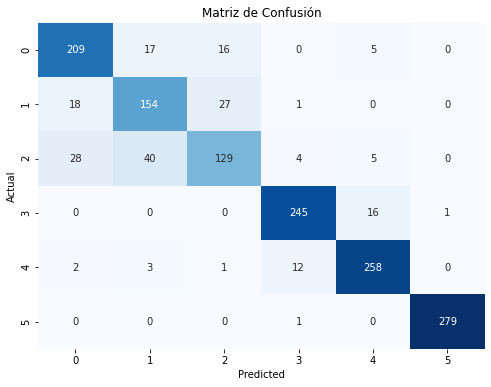

In [33]:
# visualize matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Generar la matriz de confusión
conf_matrix = confusion_matrix(Y_test, Y_pred)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

